In [5]:
# !pip install datasets
!pip install tensorflow==2.14.1
!pip install keras==2.14.0
!pip install wurlitzer
!pip install ml-dtypes==0.2.0
!pip install pydantic==1.10.11

In [2]:
import os
import numpy as np
import h5py
import cv2
import tifffile
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

import keras
import tensorflow

2024-07-30 05:38:44.808265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 05:38:44.808362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 05:38:44.945590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
output_image_dir = "/kaggle/working/images"
output_label_dir = "/kaggle/working/labels"
if not os.path.exists(output_image_dir):
    os.mkdir(output_image_dir)
if not os.path.exists(output_label_dir):
    os.mkdir(output_label_dir)

In [4]:
def list_files(folder, extension='.tiff'):
    filenames = os.listdir(folder)
    filepaths = [os.path.join(folder, filename) for filename in filenames]
    return filepaths

def load_image(file_path):
    tiff_data = tifffile.imread(file_path)
    np_array = np.array(tiff_data)
    return np_array

def binarize(image):
    _, binary = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)
    return binary

def create_crops(image, label, size=256):
    crops = []
    labels = []
    h, w, _ = image.shape
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            crop_img = image[i:i+size, j:j+size]
            crop_label = label[i:i+size, j:j+size]
            if np.mean(crop_label) > 0.01 and 0 < np.mean(crop_img) < 255:  # Checking if label is not 99% black
                crops.append(crop_img)
                labels.append(crop_label)
    return crops, labels

In [6]:
output_image_dir = "/kaggle/working/images"
output_label_dir = "/kaggle/working/labels"
CROP_SIZE = 256

In [10]:
def crop_and_map_labels():
    
    
    if not os.path.exists(output_image_dir):
        os.mkdir(output_image_dir)
    if not os.path.exists(output_label_dir):
        os.mkdir(output_label_dir)

        
    folders = [
        '/kaggle/input/massachusetts-roads-dataset/tiff/train',
        '/kaggle/input/massachusetts-roads-dataset/tiff/test',
        '/kaggle/input/massachusetts-roads-dataset/tiff/val'
    ]
    
    count = 0
    for folder in folders:
        image_folder = f'{folder}/'
        label_folder = f'{folder}_labels/'

        label_paths = list_files(label_folder)
        print(label_paths[0:5])

        for lbl_path in label_paths:
            image_path = os.path.join(image_folder, os.path.basename(lbl_path) + 'f')
            if not os.path.exists(image_path):
                print(f"{image_path} doesn't exist")
                continue
            image = load_image(os.path.join(image_folder, os.path.basename(lbl_path)+'f'))
            label = load_image(lbl_path)

            crops, labels = create_crops(image, label, CROP_SIZE)

            for idx, (crop_img, crop_label) in enumerate(zip(crops, labels)):
                crop_img = crop_img
                crop_label = binarize(crop_label)

                cv2.imwrite(os.path.join(output_image_dir, f"crop_{count}.png"), crop_img)
                cv2.imwrite(os.path.join(output_label_dir, f"crop_{count}.png"), crop_label)
                count = count+1
                


crop_and_map_labels()

['/kaggle/input/massachusetts-roads-dataset/tiff/train_labels/24778855_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/train_labels/24928900_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/train_labels/10828825_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/train_labels/21778960_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/train_labels/25979290_15.tif']
['/kaggle/input/massachusetts-roads-dataset/tiff/test_labels/26578720_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/test_labels/23278930_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/test_labels/10378780_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/test_labels/22078975_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/test_labels/11278840_15.tif']
['/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/10978735_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/10228690_15.tif', '/kaggle/input/massachusetts-roads-dataset/tiff/val_labels

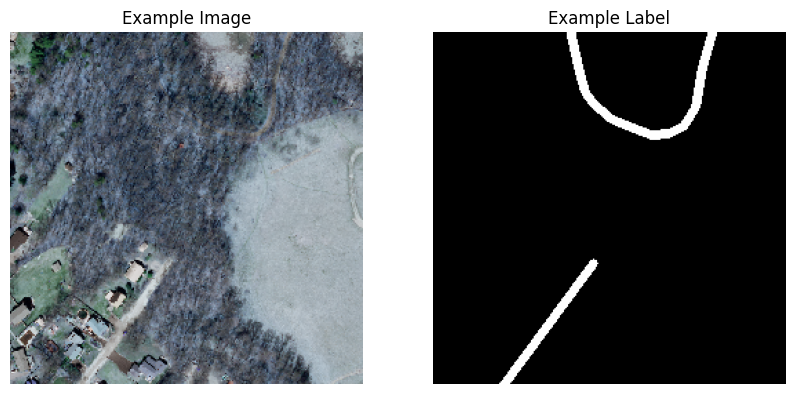

In [7]:
def display_example_images(output_image_dir, output_label_dir):
    """
    Display an example image from the output_image_dir and output_label_dir.
    """
    example_image_path = os.path.join(output_image_dir, "crop_1.png")
    example_label_path = os.path.join(output_label_dir, "crop_1.png")

    if os.path.exists(example_image_path) and os.path.exists(example_label_path):
        image = cv2.imread(example_image_path)
        label = cv2.imread(example_label_path, cv2.IMREAD_GRAYSCALE)

        # Convert BGR (OpenCV format) to RGB for matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Example Image")
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Example Label")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.show()
    else:
        print("Example images not found. Ensure at least one crop has been created.")
        
display_example_images(output_image_dir, output_label_dir)

In [8]:
paths = {"train":["/kaggle/working/images", "/kaggle/working/labels"]}
    
seed=24
batch_size= 16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
img_data_gen_args = dict(rescale = 1/255.)
mask_data_gen_args = dict()

#If You need to resize images then add this to the flow_from_directory parameters 
#target_size=(150, 150), #Or whatever the size is for your network

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(paths["train"][0], 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           classes = ["."],
                                                           class_mode=None #Very important to set this otherwise it returns multiple numpy arrays thinking class mode is binary.
                                                           )  

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(paths["train"][1], 
                                                        classes = ["."],
                                                        seed=seed, 
                                                        batch_size=batch_size,
                                                        color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None
                                                         )


train_generator = zip(image_generator, mask_generator)

print(image_generator.filenames[0:5])
print(mask_generator.filenames[0:5])

Found 41950 images belonging to 1 classes.
Found 41950 images belonging to 1 classes.
['./0.png', './1.png', './10.png', './100.png', './1000.png']
['./0.png', './1.png', './10.png', './100.png', './1000.png']


In [9]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs, outputs, name="U-NET")
    return model

In [10]:
IMAGE_HEIGHT = IMAGE_WIDTH = CROP_SIZE #256

In [11]:
u_net_model = unet(input_size=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

In [12]:
u_net_model.summary()
# tensorflow.keras.utils.plot_model(u_net_model, show_shapes=True)

Model: "U-NET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0] 

 Total params: 31,365,313 (119.65 MB)

 Trainable params: 31,353,665 (119.60 MB)

 Non-trainable params: 11,648 (45.50 KB)

In [13]:
def iou_coef(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    union = tensorflow.reduce_sum(y_true) + tensorflow.reduce_sum(y_pred) - intersection
    
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    total = tensorflow.reduce_sum(y_true) + tensorflow.reduce_sum(y_pred)
    
    return (2. * intersection + smooth) / (total + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [14]:
EPOCHS = 5
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [15]:
model_path = "/kaggle/working/aerial-image-road-segmentation-xp.keras"

checkpointer = ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only = True, verbose=1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, epsilon=1e-4)

In [16]:
opt = keras.optimizers.Adam(LEARNING_RATE)
u_net_model.compile(optimizer=opt, loss=soft_dice_loss, metrics=[iou_coef])

In [17]:
def create_generator(zipped):
    for (img, mask) in zipped:
        yield (img, mask)

# gen = create_generator(train_generator)
# first_item = next(gen)
# print(first_item)

In [18]:
history = u_net_model.fit(
    create_generator(train_generator), 
    epochs=EPOCHS,
    steps_per_epoch = len(os.listdir(paths["train"][0])) // BATCH_SIZE,
    batch_size = BATCH_SIZE,
    callbacks = [checkpointer, earlystopper, lr_reducer],
)

Epoch 1/5


2024-07-30 05:40:12.342009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.11841, expected 2.65729
2024-07-30 05:40:12.342276: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27392: 3.3488, expected 2.88768
2024-07-30 05:40:12.342415: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38656: 3.55356, expected 3.09244
2024-07-30 05:40:12.342607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.62512, expected 2.96419
2024-07-30 05:40:12.342623: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 4.47177, expected 3.81084
2024-07-30 05:40:12.342631: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 5.40808, expected 4.74715
2024-07-30 05:40:12.342639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 5.33073, expected 4.66979
2024-07-30 05:40:12.342663: E ex

2621/2621 ━━━━━━━━━━━━━━━━━━━━ 1073s 372ms/step - iou_coef: 0.3041 - loss: 0.5451 - learning_rate: 1.0000e-04
Epoch 2/5


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: iou_coef,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: iou_coef,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
2024-07-30 05:57:53.534146: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.55785, expected 1.95285
2024-07-30 05:57:53.534208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.63579, expected 2.03079
2024

2621/2621 ━━━━━━━━━━━━━━━━━━━━ 1049s 372ms/step - iou_coef: 0.5433 - loss: 0.2975 - learning_rate: 1.0000e-04
Epoch 3/5
2621/2621 ━━━━━━━━━━━━━━━━━━━━ 976s 372ms/step - iou_coef: 0.5791 - loss: 0.2681 - learning_rate: 1.0000e-04
Epoch 4/5
2621/2621 ━━━━━━━━━━━━━━━━━━━━ 975s 372ms/step - iou_coef: 0.5964 - loss: 0.2543 - learning_rate: 1.0000e-04
Epoch 5/5
2621/2621 ━━━━━━━━━━━━━━━━━━━━ 974s 371ms/step - iou_coef: 0.6101 - loss: 0.2435 - learning_rate: 1.0000e-04


In [21]:
print(history.model)

<Functional name=U-NET, built=True>


In [33]:
model_path = "/kaggle/working/aerial-image-road-segmentation-xp.keras"
u_net_model.save(model_path, save_format='keras')

In [23]:
!pip install huggingface_hub

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [24]:
#load tokens
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

In [34]:
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login

# Define repository name and local path
repo_name = "spectrewolf8/aerial-image-road-segmentation-xp"
repo_path = "spectrewolf8/aerial-image-road-segmentation-xp"

#logging into Hugging Face
!huggingface-cli login --token $hf_token

# Create a repository
api = HfApi()

api.create_repo(repo_id=repo_name, exist_ok=True)

# Initialize the local repository
repo = Repository(local_dir=repo_path, clone_from=repo_name)

# Copy the model file to the repository directory
import shutil
shutil.copy(model_path, repo_path)  # or .h5 file

# Push to the Hub
repo.push_to_hub()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/kaggle/working/spectrewolf8/aerial-image-road-segmentation-xp is already a clone of https://huggingface.co/spectrewolf8/aerial-image-road-segmentation-xp. Make sure you pull the latest changes with `repo.git_pull()`.


Upload file aerial-image-road-segmentation-xp.keras:   0%|          | 1.00/359M [00:00<?, ?B/s]

To https://huggingface.co/spectrewolf8/aerial-image-road-segmentation-xp
   8f113a7..7f272f5  main -> main



'https://huggingface.co/spectrewolf8/aerial-image-road-segmentation-xp/commit/7f272f50a107a9032e5d67ef23fe01561ac492b5'

In [36]:
def iou_coef(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    union = tensorflow.reduce_sum(y_true) + tensorflow.reduce_sum(y_pred) - intersection
    
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    total = tensorflow.reduce_sum(y_true) + tensorflow.reduce_sum(y_pred)
    
    return (2. * intersection + smooth) / (total + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [38]:
from huggingface_hub import hf_hub_download
import tensorflow as tf

# Define your model repository and file name
repo_name = "spectrewolf8/aerial-image-road-segmentation-xp"
filename = "aerial-image-road-segmentation-xp.keras"  # Update this to the actual model file name

# Download the model file from Hugging Face Hub
local_model_path = hf_hub_download(repo_id=repo_name, filename=filename)

# Load the model
model = tf.keras.models.load_model(local_model_path, custom_objects={'soft_dice_loss': soft_dice_loss, 'dice_coef': dice_coef, "iou_coef": iou_coef})

# Check the model summary
model.summary()

Model: "U-NET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0] 

 Total params: 94,072,645 (358.86 MB)

 Trainable params: 31,353,665 (119.60 MB)

 Non-trainable params: 11,648 (45.50 KB)

 Optimizer params: 62,707,332 (239.21 MB)

In [41]:
def load_test_images_and_masks(image_folder, mask_folder, size=256):
    image_paths = sorted([os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder) if fname.endswith('.png')])
    
    images = []
    masks = []
    
    for img_path, mask_path in zip(image_paths[0:10], mask_paths[0:10]):
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (size, size))
        mask = cv2.resize(mask, (size, size))
        mask = (mask > 127).astype(np.uint8)
        
        images.append(image)
        masks.append(mask)
        
    images = np.array(images) / 255.0
    masks = np.array(masks).reshape((-1, size, size, 1))
    
    return images, masks

test_image_folder = "/kaggle/working/images"
test_mask_folder = "/kaggle/working/labels"

test_images, test_masks = load_test_images_and_masks(test_image_folder, test_mask_folder)

In [43]:
from tensorflow.keras.models import load_model
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
# import keras.src.models.functional

model_path = "/kaggle/working/aerial-image-road-segmentation-xp.keras"
u_net_model = load_model(model_path, custom_objects={'soft_dice_loss': soft_dice_loss, 'dice_coef': dice_coef, "iou_coef": iou_coef})

# Evaluate the model
loss, iou = u_net_model.evaluate(test_images, test_masks, verbose=1)
# print(u_net_model.evaluate())
print(f"Test Loss: {loss}")
print(f"Test IOU: {iou}")

TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type uint8 of argument 'x'.

In [ ]:
# Make predictions
predictions = u_net_model.predict(test_images, verbose=1)

# Apply threshold to predictions
thresh_val = 0.1
prediction_threshold = (predictions > thresh_val).astype(np.uint8)

# Visualize results
num_samples = 10
f = plt.figure(figsize=(15, 25))
for i in range(1, num_samples * 4, 4):
    ix = random.randint(0, len(predictions))
    
    f.add_subplot(num_samples, 4, i)
    imshow(test_images[ix])
    plt.title("Image")
    plt.axis('off')
    
    f.add_subplot(num_samples, 4, i + 1)
    imshow(np.squeeze(test_masks[ix]))
    plt.title("Ground Truth")
    plt.axis('off')
    
    f.add_subplot(num_samples, 4, i + 2)
    imshow(np.squeeze(predictions[ix]))
    plt.title("Prediction")
    plt.axis('off')
    
    f.add_subplot(num_samples, 4, i + 3)
    imshow(np.squeeze(prediction_threshold[ix]))
    plt.title(f"Thresholded at {thresh_val}")
    plt.axis('off')

plt.show()

# TEST